Working with NASDAQ order book data
The primary source of market data is the order book, which updates in real-time throughout the day to reflect all trading activity. Exchanges typically offer this data as a real-time service for a fee but may provide some historical data for free.

In the United States, stock markets provide quotes in three tiers, namely Level I, II and III that offer increasingly granular information and capabilities:

Level I: real-time bid- and ask-price information, as available from numerous online sources
Level II: adds information about bid and ask prices by specific market makers as well as size and time of recent transactions for better insights into the liquidity of a given equity.
Level III: adds the ability to enter or change quotes, execute orders, and confirm trades and is only available to market makers and exchange member firms. Access to Level III quotes permits registered brokers to meet best execution requirements.

# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(X, y)

# Create the parameter dictionary for each tree: params 
params = {"objective":"reg:linear", "max_depth":3}

# Create list of number of boosting rounds
num_rounds = [5, 10, 15]

# Empty list to store final round rmse per XGBoost model
final_rmse_per_round = []

# Iterate over num_rounds and build one model per num_boost_round parameter
for curr_num_rounds in num_rounds:

    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=3, num_boost_round=curr_num_rounds, metrics="rmse", as_pandas=True, seed=123)
    
    # Append final round RMSE
    final_rmse_per_round.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
num_rounds_rmses = list(zip(num_rounds, final_rmse_per_round))
print(pd.DataFrame(num_rounds_rmses,columns=["num_boosting_rounds","rmse"]))

magical_data = pd.DataFrame(index=ticker_names)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
%matplotlib inline
import gzip
import shutil
from struct import unpack
from collections import namedtuple, Counter, defaultdict
from pathlib import Path
from urllib.request import urlretrieve
from urllib.parse import urljoin
from datetime import timedelta
from time import time

import pandas as pd
import mplfinance as mpf


import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [3]:
sns.set_style('whitegrid')

In [4]:
data_set1 = pd.read_csv('./data_sets/equity_trade_and_quotes_1min.csv',
                   index_col=['Ticker','Date'],
                  parse_dates=True, infer_datetime_format=True)

In [5]:
data_set2 = pd.read_csv('./data_sets/equity_trades_only_1min_adj.csv',
                   index_col=['Ticker','Date'],
                  parse_dates=True, infer_datetime_format=True)



In [6]:
data_set1

TimeBarStart         OpenBarTime  OpenBidPrice  OpenBidSize  \
Ticker Date                                                                     
AAPL   2020-01-28        04:00  04:00:00.000000000           NaN          NaN   
       2020-01-28        04:01  04:01:00.000000000        311.00        600.0   
       2020-01-28        04:02  04:02:00.000000000        310.03        100.0   
       2020-01-28        04:03  04:03:00.000000000        310.04        100.0   
       2020-01-28        04:04  04:04:00.000000000        310.41        200.0   
...                        ...                 ...           ...          ...   
       2020-01-28        19:55  19:55:00.000000000        322.45        800.0   
       2020-01-28        19:56  19:56:00.000000000        322.40       1900.0   
       2020-01-28        19:57  19:57:00.000000000        322.25       8500.0   
       2020-01-28        19:58  19:58:00.000000000        322.35        200.0   
       2020-01-28        19:59  19:59:00.000000000        322.50       2500.0   

                   OpenAskPrice  OpenAskSize      FirstTradeTime  \
Ticker Date                                                        
AAPL   2020-01-28           NaN          NaN  04:00:00.013359679   
       2020-01-28        311.70        100.0  04:01:09.900182150   
       2020-01-28        310.85        100.0  04:02:25.007722643   
       2020-01-28        310.85        100.0  04:03:14.512720103   
       2020-01-28        310.73        100.0  04:04:03.233987243   
...                         ...          ...                 ...   
       2020-01-28        322.56        100.0  19:55:01.613020927   
       2020-01-28        322.46        300.0  19:56:00.436987947   
       2020-01-28        322.35        100.0  19:57:01.670386139   
       2020-01-28        322.40        800.0  19:58:00.246250025   
       2020-01-28        322.54        300.0  19:59:05.738680880   

                   FirstTradePrice  FirstTradeSize         HighBidTime  ...  \
Ticker Date                                                             ...   
AAPL   2020-01-28           312.60            25.0  04:00:00.069948208  ...   
       2020-01-28           311.01            30.0  04:01:00.000000000  ...   
       2020-01-28           310.33             1.0  04:02:57.016029861  ...   
       2020-01-28           310.33            20.0  04:03:57.456389027  ...   
       2020-01-28           310.50             4.0  04:04:00.000000000  ...   
...                            ...             ...                 ...  ...   
       2020-01-28           322.49            76.0  19:55:29.386432437  ...   
       2020-01-28           322.46            50.0  19:56:17.062429340  ...   
       2020-01-28           322.32            42.0  19:57:13.091652988  ...   
       2020-01-28           322.35            25.0  19:58:54.784168298  ...   
       2020-01-28           322.50           300.0  19:59:18.915108368  ...   

                   FinraVolumeWeightPrice  UptickVolume DowntickVolume  \
Ticker Date                                                              
AAPL   2020-01-28                     NaN           130            716   
       2020-01-28                     NaN            30            661   
       2020-01-28                     NaN            52             11   
       2020-01-28                     NaN            50            150   
       2020-01-28                     NaN            10            120   
...                                   ...           ...            ...   
       2020-01-28               322.48746          1073           2578   
       2020-01-28               322.42450          1097           1409   
       2020-01-28               322.42413           470            850   
       2020-01-28               322.43208          1045           2918   
       2020-01-28               322.53226          2179           1624   

                   RepeatUptickVolume  RepeatDowntickVolume UnknownTickVolume  \
Ticker 

In [7]:
data_set2

SecId TimeBarStart  FirstTradePrice  HighTradePrice  \
Ticker Date                                                              
AAPL   2020-01-28  33449        04:00           312.60          312.60   
       2020-01-28  33449        04:01           311.01          311.07   
       2020-01-28  33449        04:02           310.33          310.33   
       2020-01-28  33449        04:03           310.33          310.85   
       2020-01-28  33449        04:04           310.50          310.68   
...                  ...          ...              ...             ...   
       2020-01-28  33449        19:55           322.49          322.55   
       2020-01-28  33449        19:56           322.46          322.50   
       2020-01-28  33449        19:57           322.32          322.50   
       2020-01-28  33449        19:58           322.35          322.54   
       2020-01-28  33449        19:59           322.50          322.59   

                   LowTradePrice  LastTradePrice  VolumeWeightPrice  Volume  \
Ticker Date                                                                   
AAPL   2020-01-28         311.10          311.20          311.48600    1443   
       2020-01-28         310.43          310.43          310.57852    2627   
       2020-01-28         310.30          310.33          310.31814     253   
       2020-01-28         310.33          310.73          310.72091     220   
       2020-01-28         310.41          310.68          310.42950     240   
...                          ...             ...                ...     ...   
       2020-01-28         322.40          322.40          322.46887    5500   
       2020-01-28         322.32          322.32          322.42040    5503   
       2020-01-28         322.25          322.32          322.36762    2589   
       2020-01-28         322.29          322.50          322.41442    6638   
       2020-01-28         322.50          322.50          322.53819    6401   

                   TotalTrades  FirstTradePriceAdjusted  \
Ticker Date                                               
AAPL   2020-01-28           16                  77.6145   
       2020-01-28           31                  77.2198   
       2020-01-28            7                  77.0509   
       2020-01-28            3                  77.0509   
       2020-01-28            6                  77.0931   
...                        ...                      ...   
       2020-01-28           56                  80.0701   
       2020-01-28           52                  80.0627   
       2020-01-28           39                  80.0279   
       2020-01-28           70                  80.0353   
       2020-01-28           63                  80.0726   

                   HighTradePriceAdjusted  LowTradePriceAdjusted  \
Ticker Date                                                        
AAPL   2020-01-28                 77.6145                77.2421   
       2020-01-28                 77.2347                77.0758   
       2020-01-28                 77.0509                77.0435   
       2020-01-28                 77.1800                77.0509   
       2020-01-28                 77.1378                77.0708   
...                                   ...                    ...   
       2020-01-28                 80.0850                80.0478   
       2020-01-28                 80.0726                80.0279   
       2020-01-28                 80.0726                80.0105   
       2020-01-28                 80.0825                80.0204   
       2020-01-28                 80.0949                80.0726   

                   LastTradePriceAdjusted  VolumeWeightPriceAdjusted  \
Ticker Date                                                            
AAPL   2020-01-28                 77.2669                   77.33795   
       2020-01-28                 77.0758                   77.11264   
       2020-01-28                 77.0509                   77.04799   
       2020-01-

In [8]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>5.2f}'

In [9]:
data_path = Path('data') # set to e.g. external harddrive
itch_store = str(data_path / 'itch.h5')
order_book_store = data_path / 'order_book.h5'

In [10]:
FTP_URL = 'ftp://emi.nasdaq.com/ITCH/'
SOURCE_FILE = '10302019.NASDAQ_ITCH50.gz'

In [11]:
def may_be_download(url):
    """Download & unzip ITCH data if not yet available"""
    if not data_path.exists():
        print('Creating directory')
        data_path.mkdir()
    else: 
        print('Directory exists')

    filename = data_path / url.split('/')[-1]        
    if not filename.exists():
        print('Downloading...', url)
        urlretrieve(url, filename)
    else: 
        print('File exists')        

    unzipped = data_path / (filename.stem + '.bin')
    if not unzipped.exists():
        print('Unzipping to', unzipped)
        with gzip.open(str(filename), 'rb') as f_in:
            with open(unzipped, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    else: 
        print('File already unpacked')
    return unzipped

In [12]:
#file_name = may_be_download(urljoin(FTP_URL, SOURCE_FILE))

In [13]:
import pandas as pd
import glob

path = r'./ticker_data' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

ticker_names = []

for filename in all_files:
    df = pd.read_csv(filename)
    ticker_names.append(filename[-8:])
    li.append(df)

frame = pd.concat(li, axis=0)



In [14]:
ticker_names[:9]

['AACG.csv',
 'ACQW.csv',
 'AAIC.csv',
 'AAME.csv',
 '\\AAU.csv',
 'ABEO.csv',
 'ABEV.csv',
 'ABUS.csv',
 'CACW.csv']

In [15]:
stock, data = 'AAPL', '20191020'
title = '{} | {}'.format(stock, pd.to_datetime(date).date())


# logic related to uploading and selecting data.

trades = store['{}/trades'.format(stock)].reset_index()

trades = trades[trades.cross == 0] # excluding data from open/close crossings

trades.price = trades.price.mul(1e-4)



NameError: name 'date' is not defined

In [ ]:
def get_bar_stats(agg_trades):
    vwap = agg_trades.apply(lambda x: np.average(x.price,
                                                 weights=x.shares)).to_frame('vwap')
    ohlc = agg_trades.price.ohlc()
    
    vol = agg_trades.shares.sum().to_frame('vol')
    txn = agg_trades.shares.size().to_frame('txn')
    return pd.concat([ohlc, vwap, vol, txn], axis=1)

In [ ]:
resampled = trades.groupby(pd.Grouper(freq='1Min'))
time_bars = get_bar_stats(resampled)
normaltest(time_bars.vwap.pct_change().dropna())

In [ ]:
# Displaythe reslut as a price-volume chart:

def price_volume(df, price='vwap', vol='vol', suptitle=title, fnmame=None):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(15,8))
    axes[0].plot(df.index, df[price])
    axes[1].bar(df.index, df[vol], width=1/ (len(df.index)),
                             color='r')
    dxft = mpl.dates.DateFormatter('%H:%M')
    axes[1].xaxis.set_major_locator(mpl.dates.HourLocator(interval=3))
    axes[1].xaxis.set_major_locator(xfmt)
    axes[1].get_axis().set_tick_params(which='major', pad=25)
    axes[0].set_title('Price', fontsize=14)
    axes[1].set_title('Volume', fontsize=14)
    
    fig.autofmt_xdate()
    fig.suptitle(suptitle)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

#price_volume(time_bars)
    

In [ ]:
# Alternatively, we can represent the data as a candlestick using the Bokeh plotting library

resampled = trades.groupby(pd.Grouper(freq='5Min')) # 5 Min bars for better print

df = get_bar_stats(resampled)

increase = df.close > df.open
decrease = df.open > df.close
w = 2.5 * 60 * 1000 # 2.5 min in ms
WIDGETS = "pan, wheel_zoom, box_zoon, reset, save"
p = figure(x_axis_type='datetime', tools=WIDGETS, plot_width=1500,
           title= 'AAPL Candlestick')


           
p.xaxis.major_label_orientation = pi/4

p.grid.grid_line_alpha=0.4

p.segment(df.index, df.high, df.index, df.low, color='black')

p.vbar(df.index[increase], w, df.open[increase], df.close[increase], fill_color='#D5E1DD', line_color='black')

p.vbar(df.index[decrease], w, df.open[decrease], df.close[decrease], fill_color='#D5E1DD', line_color='black')


show(p)

In [ ]:
# Volume bars offer an alternative by aggregating trade data according to volume.

min_per_trading_day = 60 * 7.5

trades_per_min = trades.shares.cumsum()
df = trades.reset_index()

by_vol = (df.groupby(df.cumul_vol.div(trades_per_min).round().astype(int)))

vol_bars = pd.concat([by_vol.timestamp.last().to_frame('timestamp'),
                      get_bar_stats(by_vol)], axis=1)
price_volume(vol_bars.set_index('timestamp'))

In [ ]:
# Accounting for price changes - dollars bars
"""
When asset prices change significatly, or after stock splits, the value of a given amount of shares changes.
Volume bars do not correrctly reflect this and can hamper the comparison of trading behavior for different periods,
that reflect such changes. In these cases, the volume bar method should be adjusted to utilize the product of shares
and prices to produce dollars bars.

The following code shows the computatiopm for dollar bars
"""

value_per_min = trades.shares.mul(trades.price).sum()/(60*7.5) # mins per training day.

trades['cummul_val'] = trades.shares.mul(trades.price).cumsum()

df = trades.reset_index()

by_value = df.groupby(df.cumul_val.div(value_per_min).round().astype(int))

dollar_bars = pd.concat([by_value.timestamp.last().to_frame('timestamp'), get_bar_stats(by_value)], axis=1)

price_volume(dollar_bars.set_index('timestamp'), suptitle=f'Dollar Bars | {stock} |{pd.to_datetime(date).date()}')



In [ ]:
"""
Algo minute bars  - equity quote and trade data:

The AlgoSeek Equity bars provide very detailed intraday quote and trade data in a suer-friendly format,
    aimed at making it easy to design and backtest intradaay ML-driven strategies. 


"""

In [ ]:
directories = [Path(d) for d in ['parquet']]

target = directories / 'equity_trades_only_1min_adj'

for zipped_file in directory.glog('*/**/*.csv'):
    fname = zipped_file.stem
    print('\t', fname)
    zf = ZipFile(zipped_file)
    files = zf.namelist()
    data = (pd.concat([pd.read_csv(zf.open(f), parse_dates=[['Date',
                                                             'TimeBarStart']])
                       for f in files],
                      ingnore_index=True)
            .rename(columns=lambda x: x.lower())
            .rename(columns={'date_timestart': 'date_time'})
            .set_index(['ticker', 'date_time']))
    data.to_parquet(target /(fname + '.parquet'))
    
    

In [ ]:
# WE can combine parquet files into a finle piece of HDF5 storage as follows
# Yielding 53.8 million records that consume 3.2 GB of memory and covering 5 yrs amd 100 stocks

path = Path('1min_trades/parquet')

df = pd.concat([pd.read_parquet(f) for f in path.glob('*.parquet')]).dropna(how='all', axis=1)

df.columns =  ['open', 'high', 'low', 'close', 'trades', 'volume', 'vwap']

df.to_hdf('data.h5', '1min_trades')



In [ ]:
# WE can use plotly to quicky create an interactive candlestick plot for one day of AAPL

idx = pd.IndexSlice
with pd.HDFStore('equity_trades_only_1min_adj.h5') as store:
    print(store.info())
    df = (store['1min_trades'].loc[idx['AAPL', '2017-12-29'], :].reset_index())
    

    
fig = gp.Figure(data=go.Ohlc(x=df.date_time,
                             open = df.open,
                             high = df.high,
                             low = df.low,
                             close = df.close))

In [ ]:
# From ticks to bars - how to regularize market data:
# To improve the noise-signal ratio and the statistical properties of the price series, we sample and regularize.
# the tick data by aggregating the trading activity

# We typically collect the open(first), high,low, and closing (last) price and volume
    # (jointlu abbreviated OHLCV) for aggregated period,
        # along side the volume-weighred ave price (vwap) and the timestmap associated with data.

# book examples 

In [ ]:
list(data_set1.columns)[:5]

In [ ]:
data_set1.drop(columns=['UnknownTickVolume',
             'CancelSize',
             'TradeAtCrossOrLocked'], inplace=True)

In [ ]:
keep = ('firsttradeprice',
        'hightradeprice',
        'lowtradeprice',
        'lasttradeprice',
        'minspread',
        'maxspread',
        'volumeweightprice',
        'nbboquotecount',
        'tradeatbid',
        'tradeatbidmid',
        'tradeatmid',
        'tradeatmidask',
        'tradeatask',
        'volume',
        'totaltrades',
        'finravolume',
        'finravolumeweightprice',
        'uptickvolume',
        'downtickvolume',
        'repeatuptickvolume',
        'repeatdowntickvolume',
        'tradetomidvolweight',
        'tradetomidvolweightrelative')

In [ ]:
equity_trade_and_quotes_1min = Path('equity_trade_and_quotes_1min')

In [ ]:
def extract_and_combine_data():
    path = nasdaq_path / '1min_taq'
    if not path.exists():
        path.mkdir(parents=True)

    data = []
    # ~80K files to process
    for f in tqdm(list(path.glob('*/**/*.csv.gz'))):
        data.append(pd.read_csv(f, parse_dates=[['Date', 'TimeBarStart']])
                    .rename(columns=str.lower)
                    .drop(tcols + drop_cols, axis=1)
                    .rename(columns=columns)
                    .set_index('date_timebarstart')
                    .sort_index()
                    .between_time('9:30', '16:00')
                    .set_index('ticker', append=True)
                    .swaplevel()
                    .rename(columns=lambda x: x.replace('tradeat', 'at')))
    data = pd.concat(data).apply(pd.to_numeric, downcast='integer')
    data.index.rename(['ticker', 'date_time'], inplace=True)
    print(data.info(show_counts=True))
    data.to_hdf(nasdaq_path / 'algoseek.h5', 'min_taq')

In [ ]:
columns = {'volumeweightprice': 'price',
           'finravolume': 'fvolume',
           'finravolumeweightprice': 'fprice',
           'uptickvolume': 'up',
           'downtickvolume': 'down',
           'repeatuptickvolume': 'rup',
           'repeatdowntickvolume': 'rdown',
           'firsttradeprice': 'first',
           'hightradeprice': 'high',
           'lowtradeprice': 'low',
           'lasttradeprice': 'last',
           'nbboquotecount': 'nbbo',
           'totaltrades': 'ntrades',
           'openbidprice': 'obprice',
           'openbidsize': 'obsize',
           'openaskprice': 'oaprice',
           'openasksize': 'oasize',
           'highbidprice': 'hbprice',
           'highbidsize': 'hbsize',
           'highaskprice': 'haprice',
           'highasksize': 'hasize',
           'lowbidprice': 'lbprice',
           'lowbidsize': 'lbsize',
           'lowaskprice': 'laprice',
           'lowasksize': 'lasize',
           'closebidprice': 'cbprice',
           'closebidsize': 'cbsize',
           'closeaskprice': 'caprice',
           'closeasksize': 'casize',
           'firsttradesize': 'firstsize',
           'hightradesize': 'highsize',
           'lowtradesize': 'lowsize',
           'lasttradesize': 'lastsize',
           'tradetomidvolweight': 'volweight',
           'tradetomidvolweightrelative': 'volweightrel'}

In [16]:
''' 
Makert and Fundamental Data: Remote data access using pandas.
Pandas enables access to data displayed on websites using read_html function
and access to the API endpoints of various data providers trhough the realted pandas-datareader library.
'''

sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_constituents = pd.read_html(sp_url, header=0)[0]

In [18]:
sp500_constituents

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
500,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
501,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
502,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [24]:
start = '2014'
end = datetime(2017, 5, 24)

yahoo= web.DataReader('GPS', 'yahoo', start=start, end=end)
yahoo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 855 entries, 2014-01-02 to 2017-05-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       855 non-null    float64
 1   Low        855 non-null    float64
 2   Open       855 non-null    float64
 3   Close      855 non-null    float64
 4   Volume     855 non-null    float64
 5   Adj Close  855 non-null    float64
dtypes: float64(6)
memory usage: 46.8 KB


In [28]:
gap_tickcer_data = yahoo.copy()

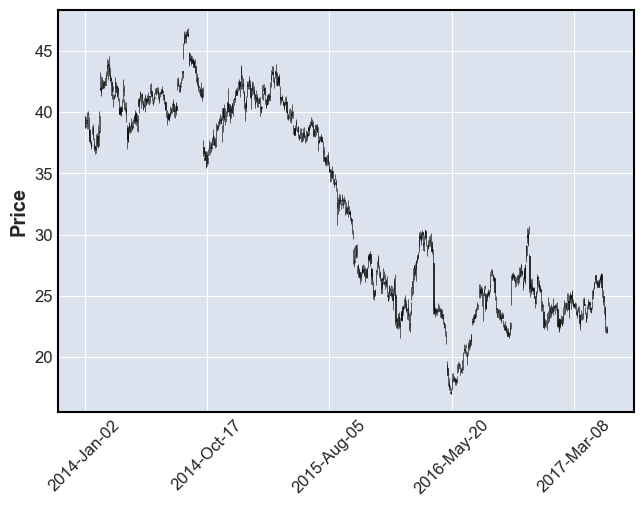

<Figure size 640x480 with 0 Axes>

In [31]:
mpf.plot(yahoo.drop('Adj Close', axis=1), type='candle')
plt.tight_layout()

In [20]:
import pandas_datareader.data as web

from datetime import datetime


In [32]:
import yfinance as yf 

symbol = 'FINV'

ticker = yf.Ticker(symbol)



In [49]:
FINV_data = ticker.history(period='2y',
                           interval='1h',
                           actions=True,
                           auto_adjust=True)

FINV_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3516 entries, 2019-12-02 09:30:00-05:00 to 2021-11-30 15:30:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3516 non-null   float64
 1   High          3516 non-null   float64
 2   Low           3516 non-null   float64
 3   Close         3516 non-null   float64
 4   Volume        3516 non-null   int64  
 5   Dividends     3516 non-null   float64
 6   Stock Splits  3516 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 219.8 KB


In [52]:
FINV_data[FINV_data.Volume > 654692]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2019-12-27 09:30:00-05:00,2.390,2.5800,2.39,2.52,878543,0.0,0
2020-02-27 09:30:00-05:00,1.730,1.8100,1.61,1.71,836170,0.0,0
2020-06-11 09:30:00-04:00,1.900,1.9000,1.80,1.83,708945,0.0,0
2020-06-12 13:30:00-04:00,1.600,1.6078,1.51,1.53,970801,0.0,0
2020-06-12 14:30:00-04:00,1.530,1.5450,1.46,1.46,1079724,0.0,0
...,...,...,...,...,...,...,...
2021-08-16 15:30:00-04:00,5.815,5.8700,5.81,5.87,839015,0.0,0
2021-08-20 09:30:00-04:00,5.840,6.2300,5.76,5.90,1099276,0.0,0
2021-08-23 09:30:00-04:00,6.370,6.4500,6.00,6.09,779436,0.0,0
2021-08-24 09:30:00-04:00,6.030,6.3300,5.94,6.22,898622,0.0,0


In [60]:
ticker.options[0]

'2021-12-17'

In [61]:
options = ticker.option_chain('2021-12-17')


In [64]:
options.puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,FINV211217P00002500,2021-11-30 19:17:46,2.5,0.03,0.0,0.10,-0.02,-40.000004,1.0,12,2.515629,False,REGULAR,USD
1,FINV211217P00005000,2021-11-30 20:17:58,5.0,0.06,0.0,0.10,-0.04,-40.000004,15.0,3044,0.656253,False,REGULAR,USD
2,FINV211217P00007500,2021-11-29 15:19:47,7.5,1.65,1.6,1.75,0.00,0.000000,50.0,4615,0.820314,True,REGULAR,USD
3,FINV211217P00010000,2021-11-12 19:32:11,10.0,3.00,3.5,4.70,0.00,0.000000,3.0,250,3.031252,True,REGULAR,USD
4,FINV211217P00012500,2021-11-12 15:04:09,12.5,5.83,5.9,7.40,0.00,0.000000,5.0,8852,1.671877,True,REGULAR,USD
5,FINV211217P00015000,2021-09-20 04:08:36,15.0,9.30,8.2,9.10,0.00,0.000000,NaN,4455,0.000010,True,REGULAR,USD


In [67]:
from zipline.api import order_target, record, symbol


def initialize(context):
    context.i = 0
    context.asset = symbol('AAPL')


ImportError: DLL load failed: The specified procedure could not be found.

In [66]:
from zipline.examples import buyapple

ImportError: DLL load failed: The specified procedure could not be found.

In [76]:
%matplotlib inline

from pathlib import Path
from datetime import date
import json
from io import BytesIO
from zipfile import ZipFile, BadZipFile
from tqdm import tqdm
import requests

import pandas_datareader.data as web
import pandas as pd

from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [77]:
'''
How to work with fundamental data: funduamental data pertains to the economic drivers determining the value of stocks.
Nature of data depends on the asset class:


Building a fundamental data time series
'''


# store data in this directory since we won't use it in other chapters
data_path = Path('funda_data') # perhaps set to external harddrive to accomodate large amount of data
if not data_path.exists():
    data_path.mkdir()

In [78]:
SEC_URL = 'https://www.sec.gov/'
FSN_PATH = 'files/dera/data/financial-statement-and-notes-data-sets/'

In [79]:
filing_periods = [(d.year, d.quarter) for d in pd.date_range('2014', '2020-09-30', freq='Q')]
filing_periods

[(2014, 1),
 (2014, 2),
 (2014, 3),
 (2014, 4),
 (2015, 1),
 (2015, 2),
 (2015, 3),
 (2015, 4),
 (2016, 1),
 (2016, 2),
 (2016, 3),
 (2016, 4),
 (2017, 1),
 (2017, 2),
 (2017, 3),
 (2017, 4),
 (2018, 1),
 (2018, 2),
 (2018, 3),
 (2018, 4),
 (2019, 1),
 (2019, 2),
 (2019, 3),
 (2019, 4),
 (2020, 1),
 (2020, 2),
 (2020, 3)]

In [81]:
for yr, qtr in tqdm(filing_periods):
    # set (and create) directory
    path = data_path / f'{yr}_{qtr}' / 'source'
    if not path.exists():
        path.mkdir(parents=True)
    
    # define url and get file
    filing = f'{yr}q{qtr}_notes.zip'
    url = SEC_URL + FSN_PATH + filing
    response = requests.get(url).content
    
    # decompress and save
    try:
        with ZipFile(BytesIO(response)) as zip_file:
            for file in zip_file.namelist():
                local_file = path / file
                if local_file.exists():
                    continue
                with local_file.open('wb') as output:
                    for line in zip_file.open(file).readlines():
                        output.write(line)
    except BadZipFile:
        print(f'\nBad zip file: {yr} {qtr}\n')
        continue

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:49<00:00,  8.50s/it]


In [83]:
for f in tqdm(sorted(list(data_path.glob('**/*.tsv')))):
    # set (and create) directory
    parquet_path = f.parent.parent / 'parquet'
    if not parquet_path.exists():
        parquet_path.mkdir(parents=True)    

    # write content to .parquet
    file_name = f.stem  + '.parquet'
    if not (parquet_path / file_name).exists():
        try:
            df = pd.read_csv(f, sep='\t', encoding='latin1', low_memory=False, error_bad_lines=False)
            df.to_parquet(parquet_path / file_name)
        except Exception as e:
            print(e, ' | ', f)
        # optional: uncomment to delete original .tsv
#         else:
            # f.unlink

100%|██████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 6982.69it/s]


In [91]:
file = data_path / '2018_3' / 'source' / '2018q3_notes-metadata.json'
with file.open() as f:
    data = json.load(f)

pprint(data)

{'@context': 'http://www.w3.org/ns/csvw',
 'dialect': {'delimiter': '\t', 'header': True, 'headerRowCount': 1},
 'tables': [{'tableSchema': {'aboutUrl': 'readme.htm',
                             'columns': [{'datatype': {'base': 'string',
                                                       'maxLength': 20,
                                                       'minLength': 20},
                                          'dc:description': 'Accession Number. '
                                                            'The 20-character '
                                                            'string formed '
                                                            'from the 18-digit '
                                                            'number assigned '
                                                            'by the Commission '
                                                            'to each EDGAR '
                                                           

In [92]:
sub = pd.read_parquet(data_path / '2018_3' / 'parquet' / 'sub.parquet')
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 40 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   adsh         6493 non-null   object 
 1   cik          6493 non-null   int64  
 2   name         6493 non-null   object 
 3   sic          6492 non-null   float64
 4   countryba    6482 non-null   object 
 5   stprba       5900 non-null   object 
 6   cityba       6482 non-null   object 
 7   zipba        6478 non-null   object 
 8   bas1         6482 non-null   object 
 9   bas2         2804 non-null   object 
 10  baph         6482 non-null   object 
 11  countryma    6448 non-null   object 
 12  stprma       5906 non-null   object 
 13  cityma       6448 non-null   object 
 14  zipma        6447 non-null   object 
 15  mas1         6448 non-null   object 
 16  mas2         2761 non-null   object 
 17  countryinc   5936 non-null   object 
 18  stprinc      5632 non-null   object 
 19  ein   

In [113]:
name = 'APPLE INC'
apple = sub[sub.name == name].T.dropna().squeeze()
key_cols = ['name', 'adsh', 'cik', 'name', 'sic', 'countryba', 'stprba',
            'cityba', 'zipba', 'bas1', 'form', 'period', 'fy', 'fp', 'filed']
apple.loc[key_cols]

name                    APPLE INC
adsh         0001193125-14-024487
cik                        320193
name                    APPLE INC
sic                          3571
countryba                      US
stprba                         CA
cityba                  CUPERTINO
zipba                       95014
bas1            ONE INFINITE LOOP
form                         10-Q
period                   20131231
fy                         2014.0
fp                             Q1
filed                    20140128
Name: 661, dtype: object

In [114]:
aapl_subs = pd.DataFrame()
for sub in data_path.glob('**/sub.parquet'):
    sub = pd.read_parquet(sub)
    aapl_sub = sub[(sub.cik.astype(int) == apple.cik) & (sub.form.isin(['10-Q', '10-K']))]
    aapl_subs = pd.concat([aapl_subs, aapl_sub])

In [115]:
aapl_nums = pd.DataFrame()
for num in data_path.glob('**/num.parquet'):
    num = pd.read_parquet(num).drop('dimh', axis=1)
    aapl_num = num[num.adsh.isin(aapl_subs.adsh)]
    print(len(aapl_num))
    aapl_nums = pd.concat([aapl_nums, aapl_num])
aapl_nums.ddate = pd.to_datetime(aapl_nums.ddate, format='%Y%m%d')   
aapl_nums.to_parquet(data_path / 'aapl_nums.parquet')

682
805
919
1271
751
942
961
1345
707
905
923
1277
738
951
1001
1364
793
952
937
1224
755
1035
1039
1176
784
1017
1028


In [116]:
aapl_nums.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26282 entries, 3544439 to 3339747
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   adsh      26282 non-null  object        
 1   tag       26282 non-null  object        
 2   version   26282 non-null  object        
 3   ddate     26282 non-null  datetime64[ns]
 4   qtrs      26282 non-null  int64         
 5   uom       26282 non-null  object        
 6   iprx      26282 non-null  int64         
 7   value     26218 non-null  float64       
 8   footnote  68 non-null     object        
 9   footlen   26282 non-null  int64         
 10  dimn      26282 non-null  int64         
 11  coreg     0 non-null      object        
 12  durp      26282 non-null  float64       
 13  datp      26282 non-null  float64       
 14  dcml      26282 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(6)
memory usage: 3.2+ MB


In [117]:
stock_split = 7
split_date = pd.to_datetime('20140604')
split_date

Timestamp('2014-06-04 00:00:00')

In [118]:
# Filter by tag; keep only values measuring 1 quarter
eps = aapl_nums[(aapl_nums.tag == 'EarningsPerShareDiluted')
                & (aapl_nums.qtrs == 1)].drop('tag', axis=1)

# Keep only most recent data point from each filing
eps = eps.groupby('adsh').apply(lambda x: x.nlargest(n=1, columns=['ddate']))

# Adjust earnings prior to stock split downward
eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(7)
eps = eps[['ddate', 'value']].set_index('ddate').squeeze().sort_index()
eps = eps.rolling(4,min_periods=4).sum().dropna()

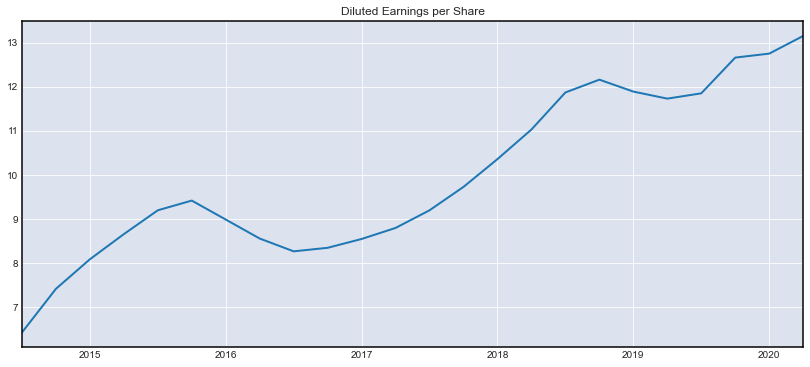

In [119]:
eps.plot(lw=2, figsize=(14, 6), title='Diluted Earnings per Share')
plt.xlabel('')
plt.savefig('diluted eps', dps=300);

In [120]:
symbol = 'AAPL.US'

aapl_stock = (web.
              DataReader(symbol, 'quandl', start=eps.index.min())
              .resample('D')
              .last()
             .loc['2014':eps.index.max()])
aapl_stock.info()

ValueError: The Quandl API key must be provided either through the api_key variable or through the environmental variable QUANDL_API_KEY.

In [ ]:
aapl_nums.tag.value_counts()

In [ ]:
fields = ['EarningsPerShareDiluted',
          'PaymentsOfDividendsCommonStock',
          'WeightedAverageNumberOfDilutedSharesOutstanding',
          'OperatingIncomeLoss',
          'NetIncomeLoss',
          'GrossProfit']

In [ ]:
dividends = (aapl_nums
             .loc[aapl_nums.tag == 'PaymentsOfDividendsCommonStock', ['ddate', 'value']]
             .groupby('ddate')
             .mean())
shares = (aapl_nums
          .loc[aapl_nums.tag == 'WeightedAverageNumberOfDilutedSharesOutstanding', ['ddate', 'value']]
          .drop_duplicates()
          .groupby('ddate')
          .mean())
df = dividends.div(shares).dropna()
ax = df.plot.bar(figsize=(14, 5), title='Dividends per Share', legend=False)
ax.xaxis.set_major_formatter(mticker.FixedFormatter(df.index.strftime('%Y-%m')))

In [105]:
txt = pd.read_parquet(data_path / '2016_2' / 'parquet' /  'txt.parquet')

In [106]:
txt.head()

,adsh,tag,version,ddate,qtrs,iprx,lang,dcml,durp,datp,dimh,dimn,coreg,escaped,srclen,txtlen,footnote,footlen,context,value
0,0000799288-16-000122,AmendmentFlag,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,5,5,None,0,FD2015Q4YTD,false
1,0000799288-16-000122,CurrentFiscalYearEndDate,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,7,7,None,0,FD2015Q4YTD,--01-29
2,0000799288-16-000122,DocumentFiscalPeriodFocus,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,2,2,None,0,FD2015Q4YTD,FY
3,0000799288-16-000122,DocumentFiscalYearFocus,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,4,4,None,0,FD2015Q4YTD,2015
4,0000799288-16-000122,DocumentPeriodEndDate,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,10,10,None,0,FD2015Q4YTD,2016-01-29
